# Time-Series Prediction

## Introduction

This tutorial tries to predict the future weather of a city using weather-data from several other cities.

We will be working with sequences of arbitrary length, we will use a Recurrent Neural Network (RNN).


## Location

We will use weather-data from the period 1980-2018 for five cities.

## Flowchart

We are trying to predict the weather for 24 hours into the future, given the current and past weather-data from 5 cities .

We use a Recurrent Neural Network (RNN) because it can work on sequences of arbitrary length. During training we will use sub-sequences of 1344 data-points (8 weeks) from the training-set, with each data-point or observation having 7 input-signals for the temperature for each of the 5 cities. We then want to train the neural network so it output the signal for tomorrow's temperature.

![Flowchart](https://i.imgur.com/EFjjHKc.png)

## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

We need to import several things from Keras.

In [0]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

## Load Data

The raw weather-data was originally obtained from the [National Climatic Data Center (NCDC), USA](https://www7.ncdc.noaa.gov/CDO/cdoselect.cmd).The following Python-module provides some functionality that may be helpful if you want to use new weather-data, but you will have to modify the source-code to fit your data-format.

In [0]:
import weather

Download the data-set if you don't have it already. It is about 35 MB.

In [0]:
weather.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


List of the cities used in the data-set.

In [0]:
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

Load and resample the data.

In [0]:
%%time
df = weather.load_resampled_data()

Wall time: 88.3 ms


These are the top rows of the data-set.

In [0]:
df.head()

Aalborg Aarhus   Esbjerg    Odense  Roskilde
                         Temp   Temp      Temp      Temp      Temp
DateTime                                                          
1980-03-01 11:00:00  5.000000    5.0  6.083333  6.142857  5.000000
1980-03-01 12:00:00  5.000000    5.0  6.583333  7.000000  5.000000
1980-03-01 13:00:00  5.000000    5.0  6.888889  7.000000  5.166667
1980-03-01 14:00:00  4.333333    5.0  6.222222  6.857143  5.833333
1980-03-01 15:00:00  4.000000    5.0  5.555556  6.000000  4.833333

Now there are only 5 input-signals in the data.

In [0]:
df.values.shape

(333109, 5)

We can verify that these two data-columns have indeed been removed.

In [0]:
df.head(1)

Aalborg Aarhus   Esbjerg    Odense Roskilde
                       Temp   Temp      Temp      Temp     Temp
DateTime                                                       
1980-03-01 11:00:00     5.0    5.0  6.083333  6.142857      5.0

### Data Errors

There are some errors in this data. As shown in the plot below, the temperature in the city of Odense suddenly jumped to almost 50 degrees C. But the highest temperature ever measured in Denmark was only 36.4 degrees Celcius and the lowest was -31.2 C. So this is clearly a data error.

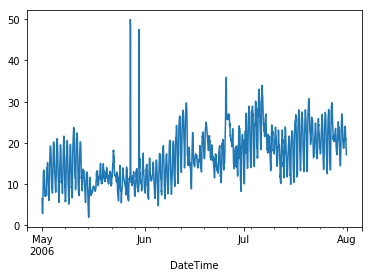

In [0]:
df['Odense']['Temp']['2006-05':'2006-07'].plot()

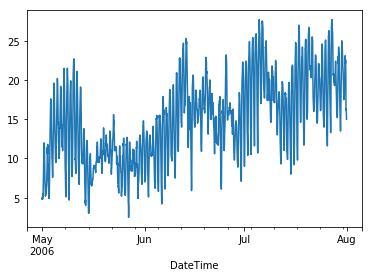

In [0]:
df['Aarhus']['Temp']['2006-05':'2006-07'].plot()

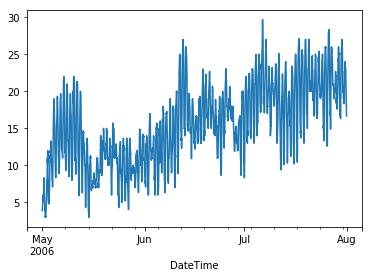

In [0]:
df['Roskilde']['Temp']['2006-05':'2006-07'].plot()

### Add Data

We can add some input-signals to the data that may help our model in making predictions.

In [0]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

### Target Data for Prediction

We will try and predict the future weather-data for this city.

In [0]:
target_city = 'Odense'

We will try and predict these signals.

In [0]:
target_names = ['Temp']

**Shifting**

In [0]:
shift_days = 1
shift_steps = shift_days * 24

Create a new data-frame with the time-shifted data.

In [0]:
df_targets = df[target_city][target_names].shift(-shift_steps)

This is the first `shift_steps + 5` rows of the original data-frame:

In [0]:
df[target_city][target_names].head(shift_steps + 5)

Temp
DateTime                     
1980-03-01 11:00:00  6.142857
1980-03-01 12:00:00  7.000000
1980-03-01 13:00:00  7.000000
1980-03-01 14:00:00  6.857143
1980-03-01 15:00:00  6.000000
1980-03-01 16:00:00  4.909091
1980-03-01 17:00:00  3.953488
1980-03-01 18:00:00  3.674419
1980-03-01 19:00:00  3.395349
1980-03-01 20:00:00  3.116279
1980-03-01 21:00:00  2.837209
1980-03-01 22:00:00  2.558140
1980-03-01 23:00:00  2.279070
1980-03-02 00:00:00  2.000000
1980-03-02 01:00:00  2.076923
1980-03-02 02:00:00  2.538462
1980-03-02 03:00:00  3.000000
1980-03-02 04:00:00  3.000000
1980-03-02 05:00:00  2.916667
1980-03-02 06:00:00  2.416667
1980-03-02 07:00:00  2.000000
1980-03-02 08:00:00  2.142857
1980-03-02 09:00:00  3.000000
1980-03-02 10:00:00  2.833333
1980-03-02 11:00:00  2.000000
1980-03-02 12:00:00  2.000000
1980-03-02 13:00:00  0.166667
1980-03-02 14:00:00  1.000000
1980-03-02 15:00:00  1.000000

The following is the first 5 rows of the time-shifted data-frame. This should be identical to the last 5 rows shown above from the original data, except for the time-stamp.

In [0]:
df_targets.head(5)

Temp
DateTime                     
1980-03-01 11:00:00  2.000000
1980-03-01 12:00:00  2.000000
1980-03-01 13:00:00  0.166667
1980-03-01 14:00:00  1.000000
1980-03-01 15:00:00  1.000000

The time-shifted data-frame has the same length as the original data-frame, but the last observations are `NaN` (not a number) because the data has been shifted backwards so we are trying to shift data that does not exist in the original data-frame.

In [0]:
df_targets.tail()

Temp
DateTime                 
2018-03-01 19:00:00   NaN
2018-03-01 20:00:00   NaN
2018-03-01 21:00:00   NaN
2018-03-01 22:00:00   NaN
2018-03-01 23:00:00   NaN

### NumPy Arrays

These are the input-signals:

In [0]:
x_data = df.values[0:-shift_steps]

In [0]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 7)


These are the output-signals :

In [0]:
y_data = df_targets.values[:-shift_steps]

In [0]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 1)


This is the number of observations in the data-set:

In [0]:
num_data = len(x_data)
num_data

333085

This is the fraction of the data-set that will be used for the training-set:

In [0]:
train_split = 0.9

This is the number of observations in the training-set:

In [0]:
num_train = int(train_split * num_data)
num_train

299776

This is the number of observations in the test-set:

In [0]:
num_test = num_data - num_train
num_test

33309

### Scaled Data

The data-set contains a wide range of values:

In [0]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -27.0
Max: 366.0


We first create a scaler-object for the input-signals.

In [0]:
x_scaler = MinMaxScaler()

We then detect the range of values from the training-data and scale the training-data.

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [0]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


We use the same scaler-object for the input-signals in the test-set.

In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has almost 300k observations, consisting of 20 input-signals and 3 output-signals.

These are the array-shapes of the input and output data:

In [0]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 7)
(299776, 1)


Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [0]:
batch_size = 256

We will use a sequence-length of 1344, which means that each random sequence contains observations for 8 weeks. One time-step corresponds to one hour, so 24 x 7 time-steps corresponds to a week, and 24 x 7 x 8 corresponds to 8 weeks.

In [0]:
sequence_length = 24 * 7 * 8
sequence_length

1344

We then create the batch-generator.

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

We can then test the batch-generator to see if it works.

In [0]:
x_batch, y_batch = next(generator)

This gives us a random batch of 256 sequences, each sequence having 1344 observations, and each observation having 7 input-signals and 1 output-signal.

In [0]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 7)
(256, 1344, 1)


We can plot one of the 7 input-signals as an example.

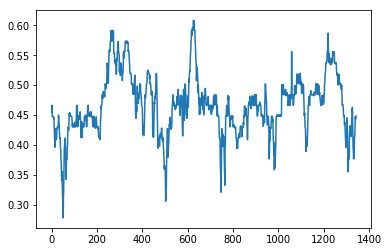

In [0]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

We can also plot one of the output-signals that we want the model to learn how to predict given all those 7 input signals.

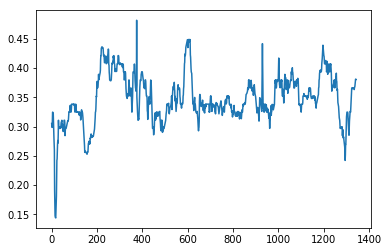

In [0]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Recurrent Neural Network

In [0]:
model = Sequential()

We can now add a Gated Recurrent Unit (GRU) to the network. This will have 512 outputs for each time-step in the sequence.

In [0]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

The GRU outputs a batch of sequences of 512 values. We want to predict 1 output-signal, so we add a fully-connected (or dense) layer which maps 512 values down to only 1 value.

The output-signals in the data-set have been limited to be between 0 and 1 using a scaler-object. So we also limit the output of the neural network using the Sigmoid activation function, which squashes the output to be between 0 and 1.

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values.

In [0]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [0]:
warmup_steps = 50

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [0]:
optimizer = RMSprop(lr=1e-3)

We then compile the Keras model so it is ready for training.

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

This is a very small model with only two layers. The output shape of `(None, None, 1)` means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 1 signal. This corresponds to the target signal we want to predict.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         798720    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 799,233
Trainable params: 799,233
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

In [0]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 11s - loss: 0.0079
Epoch 00001: val_loss improved from inf to 0.00571, saving model to 23_checkpoint.keras
100/100 [==============================] - 1145s 11s/step - loss: 0.0079 - val_loss: 0.0057
Epoch 2/20
 99/100 [============================>.] - ETA: 11s - loss: 0.0030
Epoch 00002: val_loss improved from 0.00571 to 0.00203, saving model to 23_checkpoint.keras
100/100 [==============================] - 1147s 11s/step - loss: 0.0030 - val_loss: 0.0020
Epoch 3/20
 99/100 [============================>.] - ETA: 11s - loss: 0.0022
Epoch 00003: val_loss improved from 0.00203 to 0.00165, saving model to 23_checkpoint.keras
100/100 [==============================] - 1148s 11s/step - loss: 0.0022 - val_loss: 0.0017
Epoch 4/20
 99/100 [============================>.] - ETA: 11s - loss: 0.0019
Epoch 00004: val_loss improved from 0.00165 to 0.00157, saving model to 23_checkpoint.keras

Epoch 00004: ReduceLROnPlateau reducing learnin

### Load Checkpoint

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [0]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 15s 15s/step


In [0]:
print("loss (test-set):", result)

loss (test-set): 0.0009814724326133728


In [0]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Generate Predictions

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

This plot only show the output-signal and not the 7 input-signals used to predict the output-signals. The time-shift between the input-signals and the output-signals is held fixed in these plots.So the plot's x-axis merely shows how many time-steps of the input-signals have been seen by the predictive model so far.

The prediction is not very accurate for the first 30-50 time-steps because the model has seen very little input-data at this point.

The model generates a single time-step of output data for each time-step of the input-data, so when the model has only run for a few time-steps, it knows very little of the history of the input-signals and cannot make an accurate prediction. The model needs to "warm up" by processing perhaps 30-50 time-steps before its predicted output-signals can be used.

That is why we ignore this "warmup-period" of 50 time-steps when calculating the mean-squared-error in the loss-function.

In [0]:
plot_comparison(start_idx=100000, length=1000, train=True)

![Flowchart](https://i.imgur.com/Q2teNpc.png)

## Conclusion

And this was how to use a Recurrent Neural Network to predict several time-series from a number of input-signals. We used weather-data for 5 cities to predict tomorrow's weather for one of the cities.

It worked reasonably well for predicting the temperature where the daily oscillations were predicted well, but the peaks were sometimes not predicted so accurately.